# Modelling & Inference

In [290]:
import os

import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width',50)
pd.set_option('display.max_colwidth', 20)

**Load Cleaned Datasets for Modeling**

In [53]:
# --- Configurations ---
HYPERPARAMETER_TUNING = False  # Set to True to enable tuning

# --- Paths ---
cleaned_datasets_path = os.path.abspath('cleaned_datasets')

# --- Utility: Dataset Loader ---
def load_dataset(filename: str) -> pd.DataFrame:
    """Load a CSV dataset from the cleaned datasets directory."""
    file_path = os.path.join(cleaned_datasets_path, filename)
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    return pd.read_csv(file_path)

# --- Load Cleaned Datasets ---
try:
    df_sale = load_dataset('rumah123_2025_sale_properties_cleaned.csv')
    df_rent = load_dataset('rumah123_2025_rent_properties_cleaned.csv')
    df_sale_2023 = load_dataset('rumah123_2023_sale_properties_cleaned.csv')
except FileNotFoundError as e:
    print("❌ Dataset loading failed:", e)
    raise SystemExit(1)

df_sale_train, df_sale = train_test_split(df_sale, test_size=0.5, random_state=42)

## MODELLING

### 2023 Property Sale Price Prediction Model

**Feature and Target Preparation (Sale 2023)**

We prepare the dataset for supervised learning by separating features (`X`) and the target variable (`y`).

- **Target**: `price_in_rp`, the actual selling price of the house in Indonesian Rupiah (2023 data).
- **Dropped Columns**: 
  - `url`, `title`, and `description` are excluded due to being unstructured or irrelevant for this model.
  - `price_in_rp` is removed from `X` because it's the target.

Categorical columns such as `city`, `district`, `certificate`, and `property_condition` are encoded using **One-Hot Encoding** with `drop_first=True` to avoid multicollinearity.

This ensures the dataset is ready for **XGBoost Regressor**.


In [54]:
X = df_sale_2023.drop(['price_in_rp', 'url', 'title', 'description'], axis=1).copy()
X_encoded = pd.get_dummies(X, columns=['city', 'district', 'certificate', 'property_condition'], drop_first=True, dtype=int, prefix='cat')

y = df_sale_2023['price_in_rp'].copy()

**Prepare 2025 Sale Dataset for Prediction**

To perform inference using the model trained on 2023 sale data, we must ensure the 2025 sale dataset has the same feature structure and encoding scheme.

- Non-feature columns (`url`, `title`, `description`, and `price_in_rp`) are dropped.
- Categorical features (`city`, `district`, `certificate`, `property_condition`) are encoded using One-Hot Encoding with `drop_first=True` for consistency and to avoid the dummy variable trap.
- The resulting `X_sale_2025_encoded` will later be aligned with the training data columns to ensure a valid input format for the model.


In [55]:
# Prepare the dataset for sale properties in 2023. We want to make sure the 2023_sale dataset have the same OHE features as the 2025_sale dataset.
df_sale_2025 = df_sale.copy()
X_sale_2025 = df_sale_2025.drop(['price_in_rp', 'url', 'title', 'description'], axis=1).copy()
X_sale_2025_encoded = pd.get_dummies(X_sale_2025, columns=['city', 'district', 'certificate', 'property_condition'], drop_first=True, dtype=int, prefix='cat')

**Align Feature Columns Between 2023 and 2025 Datasets**

To ensure compatibility between the 2023-trained model and 2025 input data, we align the one-hot encoded columns between:

- `X_encoded`: feature matrix from 2023 sale data (training)
- `X_sale_2025_encoded`: feature matrix from 2025 sale data (inference)

This is done using `DataFrame.reindex()`:
- Missing columns in `X_sale_2025_encoded` are filled with zeros.
- Extra columns are automatically dropped to match the 2023 column set.

The aligned 2025 dataset (`X_sale_to_sale_2023`) is now ready for prediction using the 2023-trained model.


In [56]:
# --- Ensure unique columns before reindexing ---
X_sale_2025_encoded = X_sale_2025_encoded.loc[:, ~X_sale_2025_encoded.columns.duplicated()]

# --- Align 2025 features with 2023 training data ---
X_sale_2025_encoded = X_sale_2025_encoded.reindex(columns=X_encoded.columns, fill_value=0)

# Backup for later inference
X_sale_to_sale_2023 = X_sale_2025_encoded.copy()

# Sanity check
assert X_sale_2025_encoded.shape[1] == X_sale_to_sale_2023.shape[1], "Column count mismatch after alignment"
assert (X_sale_2025_encoded.columns == X_sale_to_sale_2023.columns).all(), "Column names/order mismatch"

print(X_sale_2025_encoded.shape, X_sale_to_sale_2023.shape)

(3324, 373) (3324, 373)


**Train-Test Split**

We divide the 2023 house sale dataset into training and testing sets using an 90/10 split.

- `X_train`, `y_train`: used for training the model
- `X_test`, `y_test`: reserved for model evaluation

A `random_state` of 42 ensures reproducibility across experiments.


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.1, random_state=42)

**Log-Transform Target Variable**

Real estate prices are typically right-skewed, which can negatively impact the performance of regression models.

To address this, we apply a log transformation using `np.log1p()` to both the training and test target variables. This transformation:
- Compresses large values
- Helps the model focus on relative differences
- Often leads to lower RMSE and better generalization

> Note: We'll use `np.expm1()` later to revert predictions back to the original scale.


In [58]:
# --- Log-transform the target variable ---
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

**Hyperparameter Tuning (Grid Search)**

To optimize model performance, we perform hyperparameter tuning using `GridSearchCV` on the following key XGBoost parameters:

- `n_estimators`: number of boosting rounds
- `learning_rate`: step size shrinkage
- `max_depth`: maximum depth of trees
- `subsample`: fraction of samples used per tree
- `colsample_bytree`: fraction of features used per tree
- `gamma`: minimum loss reduction required for a split

We use:
- **3-fold cross-validation**
- **Negative mean squared error** as the scoring metric
- **Random state** for reproducibility

> Best parameters are saved in `grid_search.best_params_`, and the optimized model is stored in `best_model`.

> Note: The tuning process can take several minutes depending on grid size and dataset size.


In [59]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# --- Hyperparameter tuning via GridSearchCV ---
if HYPERPARAMETER_TUNING:
    param_grid = {
        "n_estimators": [200, 500, 1000],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 7],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
        "gamma": [0, 0.1],
        # Optional:
        # "reg_lambda": [0, 1],
        # "reg_alpha": [0, 1],
    }

    grid_search = GridSearchCV(
        estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=3,
        verbose=1,
        n_jobs=-1  # Use all cores for speed
    )

    grid_search.fit(X_train, y_train)

    print("Best Parameters:", grid_search.best_params_)
    best_model = grid_search.best_estimator_

**Train Final XGBoost Model**

We train the final `XGBRegressor` model using the training portion of the 2023 house sale dataset. The chosen hyperparameters were either manually selected or obtained from grid search:

- `n_estimators = 1000`
- `learning_rate = 0.01`
- `max_depth = 7`
- `subsample = 1.0`
- `colsample_bytree = 0.8`
- `gamma = 0`

The objective function is set to `'reg:squarederror'` for regression tasks.

> We convert the inputs to `.to_numpy()` for compatibility and performance.


In [60]:
# --- Train Final Model on 2023 House Sale Data ---
sale_2023_model = xgb.XGBRegressor(
                            objective='reg:squarederror',
                            n_estimators=1000,
                            learning_rate=0.01,
                            max_depth=7,
                            subsample=1.0,
                            colsample_bytree=0.8,
                            gamma=0,
                            random_state=42
                            )

sale_2023_model.fit(X_train.to_numpy(), y_train.to_numpy())

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


**Evaluate Model Performance (RMSE)**

We evaluate the XGBoost model using **Root Mean Squared Error (RMSE)** in two scales:

1. **Log-scale RMSE**  
   This is the scale used during training. It helps reduce skewness and makes the regression task more stable.
   
   If the model achieves a **log-scale RMSE of 0.20**, which translates roughly to an average multiplicative prediction error of:

   $e^{0.20} - 1 \approx 22\%$

   This means that, on average, the predicted property prices deviate from the actual values by about **±22%**.

2. **Rupiah RMSE**  
   We use `np.expm1()` to reverse the log transformation (`log1p`) and compute the RMSE in actual price units (IDR), which is more interpretable for business and investment decisions.

> A lower RMSE (in either scale) indicates a more accurate prediction.


In [61]:
# RMSE in log-scale
reg_xgb_pred = sale_2023_model.predict(X_test.to_numpy())  # in log-scale
rmse_log = np.sqrt(MSE(y_test, reg_xgb_pred))
print(f"RMSE (log-scale): {rmse_log:.2f}")

# RMSE in rupiah
y_test_rp = np.expm1(y_test)
reg_xgb_pred_rp = np.expm1(reg_xgb_pred)
mse_rupiah = MSE(y_test_rp, reg_xgb_pred_rp)
rmse_rupiah = np.sqrt(mse_rupiah)
print(f"RMSE in Rupiah: {rmse_rupiah:,.0f} IDR")

RMSE (log-scale): 0.26
RMSE in Rupiah: 561,034,167 IDR


**Prediction Inference**

After training the XGBoost model on log-transformed prices using `log1p(price)`, we reverse the transformation using `expm1(log_price)` to obtain predicted prices in actual Rupiah.


In [62]:
# inference example (expm1 is used to back-transform the logₑ(price) to actual Rupiah price)
pred_log = sale_2023_model.predict(X_test.to_numpy())
pred_price = np.expm1(pred_log)
print(pred_price)

[2.11446224e+08 3.45838944e+08 1.03411430e+09 8.65983360e+08
 1.18176397e+09 5.58000064e+08 1.15006554e+09 1.68669773e+09
 4.25818829e+09 7.63920128e+08 1.38925363e+09 2.00214746e+09
 3.05052979e+09 3.42843392e+08 4.70812826e+09 4.44173824e+09
 3.56103168e+08 5.35398656e+08 4.73648928e+08 5.13898880e+08
 1.77032307e+09 1.30177651e+09 3.49705600e+09 4.93732160e+08
 3.06858522e+09 1.00055597e+09 3.63941581e+09 5.60415936e+08
 3.32711904e+08 1.57342912e+09 1.63887142e+09 3.12072141e+09
 1.02186573e+09 3.55302592e+08 6.80435456e+08 1.35497920e+09
 1.20176922e+09 5.41903040e+08 1.52648653e+09 1.53335565e+09
 4.10080435e+09 7.46104384e+08 7.45657664e+08 9.87852864e+08
 2.68849101e+09 1.00994138e+09 2.11250022e+09 1.86696499e+09
 9.30561280e+08 1.08282304e+09 5.85170995e+09 1.23079872e+09
 1.25508122e+09 5.13898880e+08 3.52717363e+09 1.32466701e+09
 9.90382784e+08 4.69075488e+08 6.48040064e+08 1.45522291e+09
 1.38300365e+09 2.61857946e+09 1.13683597e+09 8.66169984e+08
 7.54949632e+08 1.470866

**Prediction Accuracy Visualization**

The plot below compares the predicted and actual property prices for 2023 sale listings. Both predictions and actual prices are back-transformed from the log scale to actual Rupiah using `np.expm1()`.

The red dashed line represents the ideal case where predictions match actual prices perfectly. The closer the points are to this line, the better the model's performance.


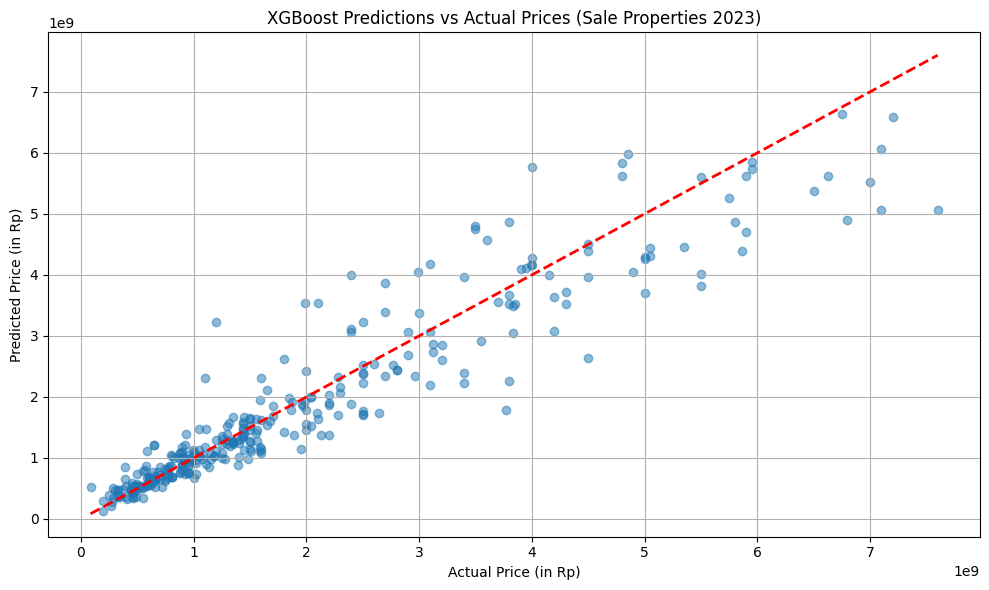

In [63]:
plt.figure(figsize=(10, 6))

# Convert back to original price scale
y_test_rp = np.expm1(y_test)
pred_rp = np.expm1(reg_xgb_pred)

plt.scatter(y_test_rp, pred_rp, alpha=0.5)
plt.plot([y_test_rp.min(), y_test_rp.max()], [y_test_rp.min(), y_test_rp.max()], 'r--', lw=2)

plt.xlabel('Actual Price (in Rp)')
plt.ylabel('Predicted Price (in Rp)')
plt.title('XGBoost Predictions vs Actual Prices (Sale Properties 2023)')
plt.grid(True)
plt.tight_layout()
plt.show()


### 2025 Property Rent Price Prediction Model

**Feature & Target Preparation (Rent 2025)**

We drop the non-predictive columns such as `url`, `title`, and `description`, and apply **One-Hot Encoding** to categorical variables to make them compatible with XGBoost.

The target variable for this regression task is `rent_price_per_year`, representing the annual rent price in Indonesian Rupiah (Rp).


In [64]:
X_rent = df_rent.drop(['rent_price_per_year', 'url', 'title', 'description'], axis=1).copy()
X_rent_encoded = pd.get_dummies(X_rent, columns=['city', 'district', 'certificate', 'property_condition'], drop_first=True, dtype=int, prefix='cat')

y_rent = df_rent['rent_price_per_year'].copy()

**Aligning Feature Set: 2025 Rent vs. 2023 Sale**

To ensure consistent model input dimensions between the **2023 sale price model** and the **2025 rent prediction**, we replicate the one-hot encoding process for the 2025 sale dataset.

We will use this encoded structure (`X_sale_2025_encoded`) as a reference when ensuring the rent dataset uses the same feature dimensions, avoiding misalignment during prediction or model application.


In [65]:
# Prepare the dataset for rent properties in 2025. We want to make sure the 2023_sale dataset have the same OHE features as the 2025_rent dataset.
df_sale_2025 = df_sale.copy()
X_sale_2025 = df_sale_2025.drop(['price_in_rp', 'url', 'title', 'description'], axis=1).copy()
X_sale_2025_encoded = pd.get_dummies(X_sale_2025, columns=['city', 'district', 'certificate', 'property_condition'], drop_first=True, dtype=int, prefix='cat')

**Ensuring Feature Alignment for Inference (Rent Model → 2025 Sale Dataset)**

To apply the rent prediction model trained on 2025 rental properties to 2025 sale listings, we must ensure both datasets have the **exact same feature dimensions and ordering**.

This step:
- Removes duplicated columns
- Merges and sorts all possible features between the two datasets
- Fills missing columns with `0` to maintain consistency
- Reorders columns to match perfectly

This guarantees that the rent model can safely predict `NOI` or `rent_price` for sale listings in 2025 using aligned features.


In [66]:
# Remove duplicate columns
X_rent_encoded = X_rent_encoded.loc[:, ~X_rent_encoded.columns.duplicated()]
X_sale_2025_encoded = X_sale_2025_encoded.loc[:, ~X_sale_2025_encoded.columns.duplicated()]

# Ensure both datasets have the same set of columns
all_columns = sorted(set(X_rent_encoded.columns).union(X_sale_2025_encoded.columns))

X_rent_encoded = X_rent_encoded.reindex(columns=all_columns, fill_value=0)
X_sale_2025_encoded = X_sale_2025_encoded.reindex(columns=all_columns, fill_value=0)

# Match column order (ensured already by sorted union)
X_rent_to_sale_2025 = X_sale_2025_encoded.copy()

# Sanity check
assert X_rent_encoded.shape[1] == X_rent_to_sale_2025.shape[1], "Column count mismatch after alignment"
assert (X_rent_encoded.columns == X_rent_to_sale_2025.columns).all(), "Column names/order mismatch"

print(X_rent_encoded.shape, X_rent_to_sale_2025.shape)

(7245, 1013) (3324, 1013)


In [67]:
X_rent_train, X_rent_test, y_rent_train, y_rent_test = train_test_split(X_rent_encoded, y_rent, test_size=0.2, random_state=42)

In [68]:
# Log-transform the target variable to reduce skewness and improve model performance
y_rent_train = np.log1p(y_rent_train)
y_rent_test = np.log1p(y_rent_test)

In [69]:
# Hyperparameter tuning
'''
- n_estimators
- learning_rate
- max_depth
- subsample
- colsample_bytree
- gamma
- lambda alpha
'''

if HYPERPARAMETER_TUNING:
    param_grid = {
        "n_estimators": [200, 500, 1000],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 5, 7, 9],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "gamma": [0, 0.1],
    }

    grid_search = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=param_grid, cv=2, scoring='neg_mean_squared_error', verbose=1, n_jobs=1)

    grid_search.fit(X_rent_train, y_rent_train)

    print("Best Parameters:", grid_search.best_params_)

In [70]:
rent_2025_model = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=1000,
                            learning_rate=0.1,
                            max_depth=5,
                            subsample=1.0,
                            colsample_bytree=0.6,
                            gamma=0,
                            random_state=42)

rent_2025_model.fit(X_rent_train.to_numpy(), y_rent_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.6
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [283]:
# rmse in log-scale
rent_2025_pred = rent_2025_model.predict(X_rent_test.to_numpy())
rmse_log = np.sqrt(MSE(y_rent_test, rent_2025_pred))
print(f"RMSE (log-scale): {rmse_log:.2f}")

# rmse in rupiah
y_rent_test_rp = np.expm1(y_rent_test)
rent_2025_pred_rp = np.expm1(rent_2025_pred)
mse_rupiah = MSE(y_rent_test_rp, rent_2025_pred_rp)
rmse_rupiah = np.sqrt(mse_rupiah)
print(f"RMSE in Rupiah: {rmse_rupiah:,.0f} IDR")

RMSE (log-scale): 0.35
RMSE in Rupiah: 51,539,800 IDR


In [72]:
# Inference example: Predicting actual rent prices from the model's log outputs
pred_log = rent_2025_model.predict(X_rent_test.to_numpy())  # model outputs logₑ(rent)
pred_price = np.expm1(pred_log)  # convert log values back to actual rent prices in Rupiah

print(pred_price)

[3.60046440e+07 6.33361200e+07 5.68633240e+07 ... 1.13351624e+08
 7.31573920e+07 5.01997040e+07]


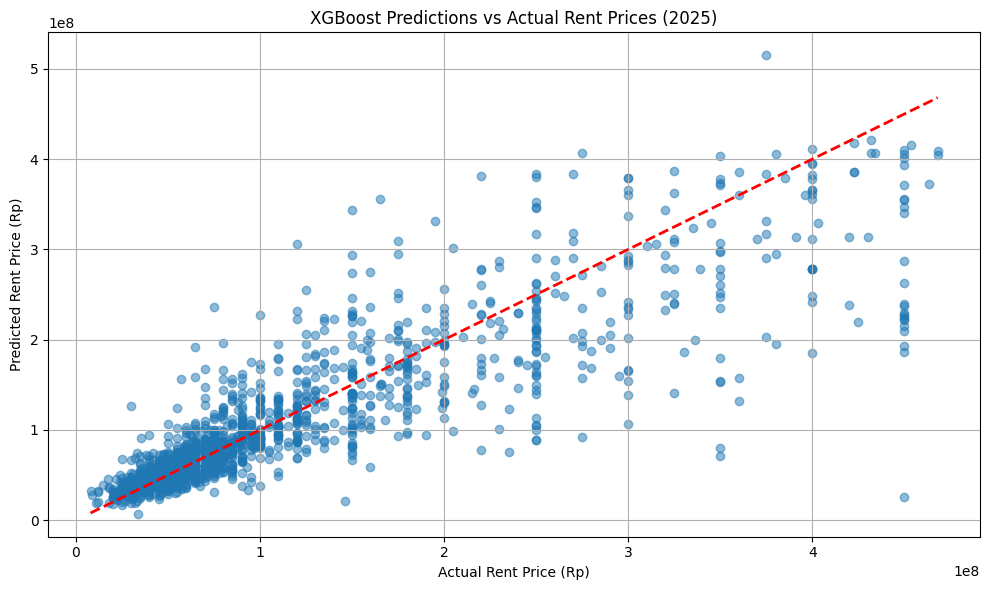

In [73]:
# Back-transform both predicted and actual values from logₑ scale to Rupiah
y_rent_test_rp = np.expm1(y_rent_test)
rent_2025_pred_rp = np.expm1(rent_2025_pred)

# Visualize predicted vs actual rent prices in Rupiah
plt.figure(figsize=(10, 6))
plt.scatter(y_rent_test_rp, rent_2025_pred_rp, alpha=0.5)
plt.plot([y_rent_test_rp.min(), y_rent_test_rp.max()],
         [y_rent_test_rp.min(), y_rent_test_rp.max()],
         'r--', lw=2)
plt.xlabel('Actual Rent Price (Rp)')
plt.ylabel('Predicted Rent Price (Rp)')
plt.title('XGBoost Predictions vs Actual Rent Prices (2025)')
plt.grid(True)
plt.tight_layout()
plt.show()


### 2025 Property Sale Price Prediction Model (to generalize current price [market price])

A 2025 property sale price model is trained to predict the actual market price for each property. This is because each property listing is made by individuals or agents, so the property can be overvalued or undervalued.

The **2025 market price** is used mainly to calculate the **annualized growth rate** (with 2023 market price).

The market price can also be used as a comparison to the listing price.

In [314]:
X_sale = df_sale_train.drop(['price_in_rp', 'url', 'title', 'description'], axis=1).copy()
X_sale_encoded = pd.get_dummies(X_sale, columns=['city', 'district', 'certificate', 'property_condition'], drop_first=True, dtype=int, prefix='cat')

y_sale = df_sale_train['price_in_rp'].copy()

In [315]:
# Remove any duplicate columns (if present)
X_sale_encoded = X_sale_encoded.loc[:, ~X_sale_encoded.columns.duplicated()]
X_sale_2025_encoded = X_sale_2025_encoded.loc[:, ~X_sale_2025_encoded.columns.duplicated()]

# Align columns: Add missing, sort, and fill with 0
X_sale_2025_encoded = X_sale_2025_encoded.reindex(columns=X_sale_encoded.columns, fill_value=0)

# Final sanity check
assert list(X_sale_2025_encoded.columns) == list(X_sale_encoded.columns), "Column mismatch after reindexing."

# Copy for use later
X_sale_to_sale_2025 = X_sale_2025_encoded.copy()
print(X_sale_2025_encoded.shape, X_sale_encoded.shape)


(3324, 365) (3324, 365)


In [316]:
X_sale_train, X_sale_test, y_sale_train, y_sale_test = train_test_split(X_sale_encoded, y_sale, test_size=0.2, random_state=42)

In [317]:
# Log-transform the target variable to reduce skewness and improve model performance
y_sale_train = np.log1p(y_sale_train)
y_sale_test = np.log1p(y_sale_test)

In [318]:
# Hyperparameter tuning
'''
- n_estimators
- learning_rate
- max_depth
- subsample
- colsample_bytree
- gamma
- lambda alpha
'''

if not HYPERPARAMETER_TUNING:
    param_grid = {
        "n_estimators": [200, 500, 1000, 5000],
        "learning_rate": [0.01, 0.1],
        "max_depth": [3, 5, 7, 9],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "gamma": [0, 0.1],
    }

    grid_search = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=param_grid, cv=2, scoring='neg_mean_squared_error', verbose=1, n_jobs=1)

    grid_search.fit(X_sale_train, y_sale_train)

    print("Best Parameters:", grid_search.best_params_)

Fitting 2 folds for each of 384 candidates, totalling 768 fits


KeyboardInterrupt: 

In [ ]:
sale_2025_model = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=1000,
                            learning_rate=0.01,
                            max_depth=7,
                            subsample=1.0,
                            colsample_bytree=0.8,
                            gamma=0,
                            random_state=42)
sale_2025_model.fit(X_sale_train.to_numpy(), y_sale_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [327]:
# rmse in log-scale
sale_2025_pred = sale_2025_model.predict(X_sale_test.to_numpy())
rmse_log = np.sqrt(MSE(y_sale_test, sale_2025_pred))
print(f"RMSE (log-scale): {rmse_log:.2f}")

# rmse in rupiah
y_sale_test_rp = np.expm1(y_sale_test)
sale_2025_pred_rp = np.expm1(sale_2025_pred)
mse_rupiah = MSE(y_sale_test_rp, sale_2025_pred_rp)
rmse_rupiah = np.sqrt(mse_rupiah)
print(f"RMSE in Rupiah: {rmse_rupiah:,.0f} IDR")

RMSE (log-scale): 0.42
RMSE in Rupiah: 1,092,622,877 IDR


In [328]:
# inference example (expm1 is used to back-transform the logₑ(price) to actual Rupiah price)
pred_log = sale_2025_model.predict(X_sale_test.to_numpy())  # model outputs logₑ(price)
pred_price = np.expm1(pred_log)  # back to actual Rupiah
print(pred_price)

[2.75195290e+09 3.29214259e+09 3.15971840e+09 1.45523674e+09
 7.28634982e+09 1.54131366e+09 7.16841728e+08 1.59455616e+09
 9.37584384e+08 1.90808819e+09 4.96048794e+09 4.40554189e+09
 1.74158067e+09 6.30014822e+09 1.46290931e+09 1.75949363e+09
 4.07367526e+09 4.76688947e+09 5.52411187e+09 1.54827328e+09
 3.58185779e+09 2.70354765e+09 3.25132518e+09 8.00250522e+09
 2.26220570e+09 2.12181619e+09 1.46276147e+09 2.00517427e+09
 5.11395994e+09 1.09809536e+09 5.25838131e+09 8.94856192e+09
 2.06820595e+09 5.48022080e+08 7.16175155e+09 4.71420960e+08
 6.02790976e+08 6.26121472e+09 3.52878208e+09 6.36328499e+09
 7.43588352e+08 9.05537024e+08 9.76851149e+09 2.46777574e+09
 6.33944064e+08 2.74306509e+09 3.16450125e+09 3.87079962e+09
 2.82254899e+09 4.74764390e+09 3.84770842e+09 3.41582515e+09
 1.53208691e+09 5.35135264e+08 6.77984384e+08 1.49019290e+09
 5.07644723e+09 5.59187008e+08 4.29279718e+09 5.24725043e+09
 2.82957261e+09 6.74850918e+09 4.32743168e+09 1.89804442e+09
 5.25961248e+08 7.645702

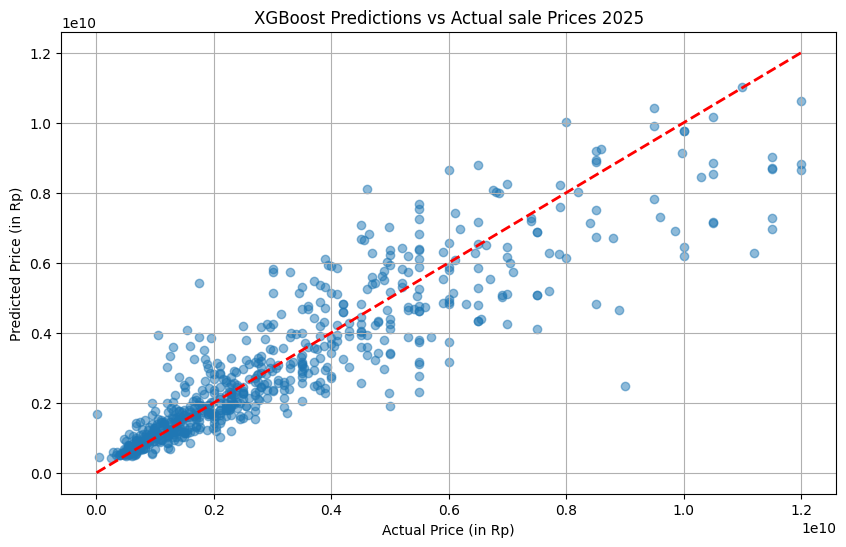

In [329]:
# Back-transform both predicted and actual values from logₑ scale to Rupiah
y_sale_test_rp = np.expm1(y_sale_test)
sale_2025_pred_rp = np.expm1(sale_2025_pred)


# visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_sale_test_rp, sale_2025_pred_rp, alpha=0.5)
plt.plot([y_sale_test_rp.min(), y_sale_test_rp.max()], [y_sale_test_rp.min(), y_sale_test_rp.max()], 'r--', lw=2)
plt.xlabel('Actual Price (in Rp)')
plt.ylabel('Predicted Price (in Rp)')
plt.title('XGBoost Predictions vs Actual sale Prices 2025')
plt.grid()
plt.show()


## INFERENCE: 2025 Property Sale Investment Features Integration 

In [83]:
# Add Property Sale Investment Features
df_sale_2025 = df_sale.copy()

# Market price for 2025 dataset
df_sale_2025['market_price_2025'] = np.expm1(sale_2025_model.predict(X_sale_to_sale_2025.to_numpy()))

# 2023 price for 2025 dataset
df_sale_2025['market_price_2023'] = np.expm1(sale_2023_model.predict(X_sale_to_sale_2023.to_numpy()))

# 2025 rent for 2025 dataset
df_sale_2025['rent_price_per_year_2025'] = np.expm1(rent_2025_model.predict(X_rent_to_sale_2025.to_numpy()))

In [84]:
# assume 30% expense ratio
OPERATING_EXPENSE_RATIO = 0.30
df_sale_2025['NOI'] = df_sale_2025['rent_price_per_year_2025'] * (1 - OPERATING_EXPENSE_RATIO)
# calculate cap rate
df_sale_2025['cap_rate'] = df_sale_2025['NOI'] / df_sale_2025['price_in_rp'] * 100
# average cap rate
avg = df_sale_2025['cap_rate'].mean()
print(f"Average cap rate (assuming 30% OER): {avg:.2f}%")

Average cap rate (assuming 30% OER): 3.87%


In [85]:
# --- Calculate the Compound Annual Growth Rate (CAGR) ---

# Define the number of years between the two price points
num_years = 2025 - 2023

# Calculate the property value growth rate (CAGR)
# Adding a small number (epsilon) to the denominator to avoid division by zero errors
epsilon = 1e-9
df_sale_2025['property_value_growth'] = \
    ((df_sale_2025['market_price_2025'] / (df_sale_2025['market_price_2023'] + epsilon)) ** (1/num_years)) - 1

# Display the first few rows with the new column
print(df_sale_2025[['market_price_2023', 'price_in_rp', 'property_value_growth']].head())

      market_price_2023   price_in_rp  property_value_growth
2986       5.518383e+09  5.000000e+09              -0.004178
3628       3.452833e+08  1.850000e+08               0.211120
5231       5.468049e+09  7.900000e+09               0.138103
4617       1.436421e+09  3.500000e+09               0.261700
6258       5.240979e+09  5.000000e+09               0.131096


In [86]:
# --- Assumptions ---
discount_rate = 0.10
holding_period_years = 10
rent_growth_rate = 0.03
operating_expense_ratio = 0.30

# --- NPV Calculation using the new dynamic growth rate ---

# Year 1 NOI
noi_year_1 = df_sale_2025['rent_price_per_year_2025'] * (1 - operating_expense_ratio)

# Year 2 NOI
noi_year_2 = noi_year_1 * (1 + rent_growth_rate)

# Estimated Future Sale Price (Terminal Value)
# Using the calculated 'property_value_growth' for each property
# Projecting from the most recent price, 'price_in_rp'
future_sale_price = df_sale_2025['price_in_rp'] * \
    (1 + df_sale_2025['property_value_growth']) ** holding_period_years

# Calculate Present Value of all cash flows
pv_noi_year_1 = noi_year_1 / (1 + discount_rate) ** 1
pv_noi_year_2 = noi_year_2 / (1 + discount_rate) ** 2
pv_future_sale_price = future_sale_price / (1 + discount_rate) ** holding_period_years

# Calculate Final NPV
# Assuming 'price_in_rp' is the acquisition cost in 2025
df_sale_2025['NPV'] = pv_noi_year_1 + pv_noi_year_2 + pv_future_sale_price - df_sale_2025['price_in_rp']

In [87]:
df_sale_2025.to_csv('rumah123_2025_sale_modelled.csv', index=True)

### Additional Inference Result Explorations

In [300]:
df_sale_2025.columns

Index(['url', 'title', 'price_in_rp', 'district',
       'city', 'bedrooms', 'bathrooms',
       'land_size_m2', 'building_size_m2',
       'certificate', 'electricity_power',
       'property_condition', 'floor_count',
       'description', 'market_price_2025',
       'market_price_2023',
       'rent_price_per_year_2025', 'NOI',
       'cap_rate', 'property_value_growth',
       'NPV'],
      dtype='object')

In [301]:
df_sale_2025.drop(['description', 'bedrooms', 'bathrooms',
       'land_size_m2', 'building_size_m2',
       'certificate', 'electricity_power',
       'property_condition', 'floor_count',
       'description',], axis=1).sort_values('NPV', ascending=False).head(5)

,url,title,price_in_rp,district,city,market_price_2025,market_price_2023,rent_price_per_year_2025,NOI,cap_rate,property_value_growth,NPV
99,https://www.ruma...,Villa Murah Asri...,7.000000e+09,Puncak,Bogor,8.386281e+09,1.838574e+09,202866256.0,142006384.0,2.028663,1.135719,5.321842e+12
4503,https://www.ruma...,Rumah Harjamukti...,7.900000e+09,Harjamukti,Depok,8.527677e+09,2.590141e+09,271594016.0,190115808.0,2.406529,0.814486,1.170683e+12
2835,https://www.ruma...,Ter Murah Harga ...,6.900000e+09,Pondok Indah,Jakarta Selatan,7.097878e+09,2.227337e+09,179756960.0,125829872.0,1.823621,0.785136,8.675702e+11
3076,https://www.ruma...,Per meter 24.5 j...,6.760000e+09,Bendungan Hilir,Jakarta Pusat,3.710893e+09,1.177105e+09,110358968.0,77251280.0,1.142770,0.775545,8.049638e+11
4877,https://www.ruma...,Rumah Mewah Elan...,1.100000e+10,Pantai Indah Kapuk,Jakarta Utara,5.902377e+09,2.120849e+09,201751472.0,141226032.0,1.283873,0.668240,6.972785e+11


In [41]:
def format_rupiah(price_rp):
    """
    Converts a large Rupiah value into a more readable string format
    (e.g., "1 Miliar", "100 Juta").
    """
    if pd.isna(price_rp):
        return np.nan # Handle NaN values if any

    price = int(price_rp) # Convert to int for easier comparison

    if price >= 1_000_000_000_000:
        return f"{price / 1_000_000_000_000:.0f} Triliun"
    elif price >= 1_000_000_000:
        return f"{price / 1_000_000_000:.0f} Miliar"
    elif price >= 1_000_000:
        return f"{price / 1_000_000:.0f} Juta"
    elif price >= 1_000:
        return f"{price / 1_000:.0f} Ribu"
    else:
        return str(price)

# See the number of listings per district
print("Listings per district:")
print(df_sale_2025['district'].value_counts())

# Get a statistical summary of prices for each district,
# and then apply the formatting for display
print("\nPrice summary by district (formatted for display):")

# Calculate the descriptive statistics first
price_summary = df_sale_2025.sort_values('NPV', ascending=False).groupby('district')['price_in_rp'].describe().round(2)

# Create a copy to apply string formatting for display
price_summary_display = price_summary.copy()

# Apply the formatting function to relevant columns for display
for col in ['mean', 'min', 'max', '25%', '50%', '75%']:
    if col in price_summary_display.columns:
        price_summary_display[col] = price_summary_display[col].apply(format_rupiah)

print(price_summary_display)

Listings per district:
district
BSD                     76
BSD City                57
Gading Serpong          48
Kelapa Gading           34
Cakung                  26
Cibubur                 25
Sunter                  22
Cipayung                21
Sentul City             18
Jagakarsa               18
Jati Asih               18
Kota Wisata             17
Pantai Indah Kapuk      17
Alam Sutera             16
Cibinong                15
Pantai Indah Kapuk 2    15
Green Lake City         15
Summarecon Bekasi       15
Cinere                  14
Sukmajaya               13
Bojong Gede             13
Sawangan                12
Cilodong                12
Citayam                 12
Harapan Indah           12
Bogor Barat             11
Beji                    10
Pancoran Mas             9
Margonda                 9
Cilandak                 9
Bekasi Utara             9
Gunung Sindur            9
Tanjung Duren            8
Cimanggis                8
Limo                     8
Lippo Karawaci         

In [42]:
# See the number of listings per city (WITHOUT FORMATTING)

print("Listings per city:")
print(df_sale_2025['city'].value_counts())

# Get a statistical summary of prices for each city
print("\nPrice summary by city (in Billion Rp):")
print((df_sale_2025.groupby('city')['price_in_rp']).describe().round(2))

Listings per city:
city
Tangerang          232
Depok              123
Bogor              117
Jakarta Utara       94
Bekasi              85
Jakarta Timur       83
Jakarta Barat       71
Jakarta Selatan     58
Jakarta Pusat        7
Name: count, dtype: int64

Price summary by city (in Billion Rp):
                 count          mean           std          min           25%  \
city                                                                            
Bekasi            85.0  9.849647e+08  6.519067e+08  390000000.0  5.900000e+08   
Bogor            117.0  1.118325e+09  8.566949e+08  340000000.0  5.700000e+08   
Depok            123.0  1.246626e+09  1.070335e+09  340000000.0  7.400000e+08   
Jakarta Barat     71.0  3.096761e+09  1.767651e+09  670000000.0  1.900000e+09   
Jakarta Pusat      7.0  1.322429e+09  1.645320e+09  435000000.0  4.775000e+08   
Jakarta Selatan   58.0  4.432948e+09  2.741255e+09  792000000.0  1.602500e+09   
Jakarta Timur     83.0  1.583157e+09  1.142088e+09  360

In [43]:
# Top 15 districts by average NPV
print("Top districts by average NPV:")
print(df_sale_2025.groupby('district')['NPV'].mean().sort_values(ascending=False).head(15))

# Top 15 districts by average historical property growth
print("\nTop districts by average property value growth:")
print(df_sale_2025.groupby('district')['property_value_growth'].mean().sort_values(ascending=False).head(15))

Top districts by average NPV:
district
Pondok Indah        3.781357e+10
Tomang              1.618104e+10
Kemandoran          1.466248e+10
Kebayoran Baru      1.056777e+10
Cipete              1.019828e+10
Mampang Prapatan    6.735342e+09
Lebak Bulus         5.828428e+09
Beji                5.226285e+09
BSD Eminent         5.117370e+09
Cinere              4.068967e+09
Cempaka Putih       3.718580e+09
Sindang Jaya        2.684894e+09
Cibinong            2.397581e+09
Kemanggisan         2.297313e+09
Cilandak            2.152573e+09
Name: NPV, dtype: float64

Top districts by average property value growth:
district
Pondok Indah        0.271284
Kemandoran          0.231421
Kebayoran Baru      0.228201
Mampang Prapatan    0.208237
Sindang Jaya        0.205713
Tomang              0.203478
Cipete              0.188844
BSD Eminent         0.177235
Lebak Bulus         0.163040
Summarecon Bogor    0.159526
Kebagusan           0.149689
Beji                0.139421
Kemanggisan         0.137291
BSD T

In [45]:
df_sale_2025.sort_values('NPV', ascending=False).head(5)

,url,title,price_in_rp,district,city,bedrooms,bathrooms,land_size_m2,building_size_m2,certificate,electricity_power,property_condition,floor_count,description,market_price_2025,market_price_2023,rent_price_per_year_2025,NOI,cap_rate,property_value_growth,NPV
774,https://www.rumah123.com/properti/jakarta-sela...,Rumah Pondok Indah 250m2 Di Bawah Njop,7.700000e+09,Pondok Indah,Jakarta Selatan,3.0,3.0,250.0,180.0,SHM,7700.0,Renovasi Total,1.0,*JUAL CEPAT!! Dibawah NJOP,8.786920e+09,3.982574e+09,293115840.0,205181088.0,2.664689,0.485376,1.478742e+11
414,https://www.rumah123.com/properti/jakarta-sela...,Rumah Lama Pondok Indah Jalan Lebar Harga Di B...,5.900000e+09,Pondok Indah,Jakarta Selatan,3.0,2.0,160.0,130.0,HGB,0.0,Renovasi Total,2.0,Jalan lebar\nlingkungan tenang\nstrategis\nwaj...,4.470423e+09,2.375823e+09,142289808.0,99602864.0,1.688184,0.371726,4.792881e+10
309,https://www.rumah123.com/properti/tangerang/ho...,Rumah Strategis Dekat BSD 10 Menit ke Stasiun ...,8.840000e+09,BSD,Tangerang,4.0,5.0,633.0,269.0,SHM,10600.0,Bagus,2.0,Jalan Haji Sidup\nCiputat Timur - Kota Tangera...,7.975519e+09,4.655017e+09,336114752.0,235280320.0,2.661542,0.308937,4.189107e+10
481,https://www.rumah123.com/properti/jakarta-utar...,"Turun Harga, Jual Cepat Rumah Rapih Siap Huni ...",3.500000e+09,Kelapa Gading,Jakarta Utara,3.0,3.0,90.0,1.0,SHM,11000.0,Bagus,3.0,"Turun Harga, Jual Cepat Rumah Rapih Siap Huni ...",3.281335e+09,1.643160e+09,155006608.0,108504624.0,3.100132,0.413141,3.954541e+10
144,https://www.rumah123.com/properti/bogor/hos392...,Rumah Cantik Tanah Luas 10 Menit ke RSUD Cibin...,4.420000e+09,Cibinong,Bogor,4.0,6.0,800.0,350.0,SHM,3500.0,Bagus,2.0,Jalan GOR Barat Pemda\nCibinong - Kabupaten Bo...,5.682196e+09,2.978398e+09,165350224.0,115745152.0,2.618669,0.381232,3.885257e+10


In [133]:
# Calculate price per square meter
df_sale_2025['price_per_m2'] = df_sale_2025['price_in_rp'] / df_sale_2025['building_size_m2']

# Compare average price per m2 across districts
print("Districts with the lowest average price per square meter:")
print(df_sale_2025.groupby('district')['price_per_m2'].mean().sort_values().head(15))

Districts with the lowest average price per square meter:
district
Rawa Badak      2.578947e+06
Bekasi Kota     7.421176e+06
Grand Wisata    8.201354e+06
Jonggol         8.866667e+06
Kemayoran       9.090909e+06
Cikarang        9.333333e+06
Cilebut         9.513889e+06
Citayam         9.603731e+06
Gunung Putri    9.782140e+06
Duren Sawit     9.883344e+06
Pondok Cabe     9.900990e+06
Tanah Baru      1.041667e+07
Tajur           1.045455e+07
Jati Asih       1.058765e+07
Semanan         1.066667e+07
Name: price_per_m2, dtype: float64


## Portfolio Optimization

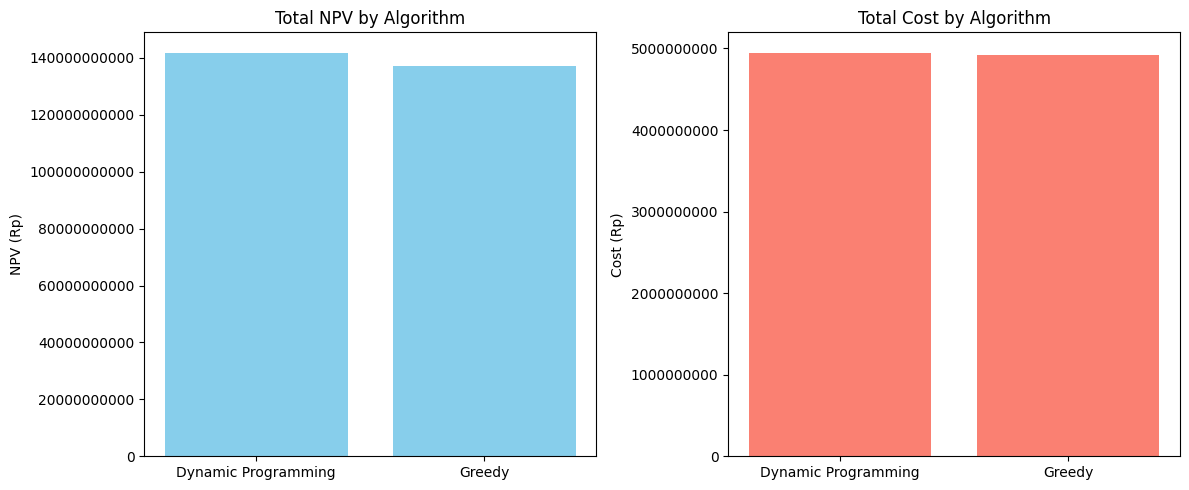

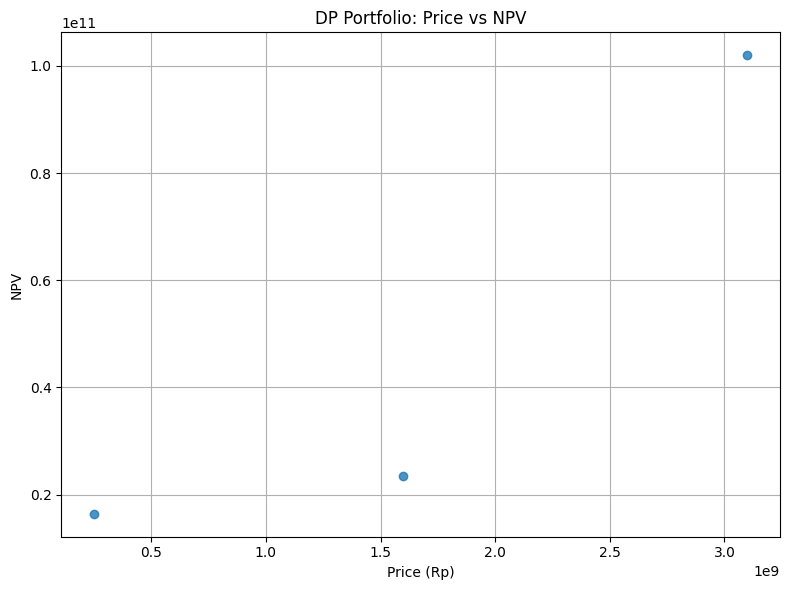

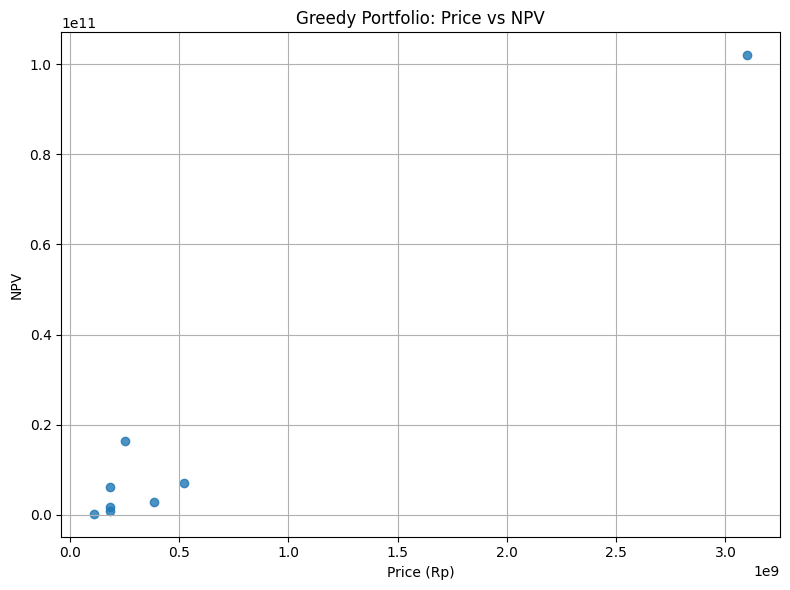

In [282]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

# Import portfolio algorithms
from algorithms import solve_portfolio_DP, solve_portfolio_greedy

# Load properties data
def load_properties_data(filename: str) -> pd.DataFrame:
    dataset_path = os.path.abspath(os.path.join(filename))
    return pd.read_csv(dataset_path, index_col=0)

# Plot summary comparison of algorithms
def plot_summary_comparison(results):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Total NPV
    axs[0].bar(results['Algorithm'], results['Total NPV'], color='skyblue')
    axs[0].set_title("Total NPV by Algorithm")
    axs[0].set_ylabel("NPV (Rp)")
    axs[0].ticklabel_format(style='plain', axis='y')

    # Total Cost
    axs[1].bar(results['Algorithm'], results['Total Cost'], color='salmon')
    axs[1].set_title("Total Cost by Algorithm")
    axs[1].set_ylabel("Cost (Rp)")
    axs[1].ticklabel_format(style='plain', axis='y')

    plt.tight_layout()
    plt.show()

# Plot selected properties (Price vs NPV)
def plot_selected_scatter(df, selections, title):
    selected = df.loc[selections]
    plt.figure(figsize=(8, 6))
    plt.scatter(selected['price_in_rp'], selected['NPV'], alpha=0.8)
    plt.xlabel("Price (Rp)")
    plt.ylabel("NPV")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Load and prepare data
budget = 5_000_000_000
data_file = r'C:\Users\balse\Documents\VScode\STIMA-Makalah\STIMA-Makalah-Analysis\rumah123_2025_sale_modelled.csv'
df = load_properties_data(data_file)
df.query('NPV > 0', inplace=True)
random_seed = random.randint(0, 1000)

properties = df[['price_in_rp', 'NPV']].sample(n=300, random_state=random_seed)

# Solve portfolios
npv_dp, sel_dp, cost_dp = solve_portfolio_DP(properties, budget)
npv_gr, sel_gr, cost_gr = solve_portfolio_greedy(properties, budget)

# Compile results
results = pd.DataFrame([
    {'Algorithm': 'Dynamic Programming', 'Total NPV': npv_dp, 'Total Cost': cost_dp},
    {'Algorithm': 'Greedy', 'Total NPV': npv_gr, 'Total Cost': cost_gr}
])

# Plot summary bar chart
plot_summary_comparison(results)

# Scatter plots of selected portfolios
plot_selected_scatter(properties, sel_dp, "DP Portfolio: Price vs NPV")
plot_selected_scatter(properties, sel_gr, "Greedy Portfolio: Price vs NPV")


349